In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-3xumkcq_
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-3xumkcq_
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=bd9a68dea47e29e93d3da6de8aa72084bd71cff124ab83fc8437c49ef0fb18ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-9z_yzvi8/wheels/db/c1/1f/a2bb07bbb4a1ce3c43921252aeafaa6205f08637e292496f04
Successfully built NVCCPlugin


In [3]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [4]:
!apt-get install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-8 fonts-dejavu-core fonts-dejavu-extra g++-8 gcc-8 gcc-8-base
  javascript-common libaccinj64-10.1 libatk-wrapper-java
  libatk-wrapper-java-jni libcublas10 libcublaslt10 libcudart10.1 libcufft10
  libcufftw10 libcuinj64-10.1 libcupti-dev libcupti-doc libcupti10.1
  libcurand10 libcusolver10 libcusolvermg10 libcusparse10 libfontenc1
  libgail-common libgail18 libgcc-8-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libjs-jquery libjs-underscore libmpx2 libncurses5 libnppc10
  libnppial10 libnppicc10 libnppicom10 libnppidei10 libnppif10 libnppig10
  libnppim10 libnppist10 libnppisu10 libnppitc10 libnpps10 libnvblas10
  libnvgraph10 libnvidia-compute-418-server libnvidia-ml-dev libnvjpeg10
  libnvrtc10.1 libnvtoolsext1 libnvvm3 libpulse-mainloop-glib0 libstdc++-8-dev
  libthrust-dev libvdpau-dev libxkbfile1 libxtst6 libxxf86dga1 node-

In [5]:
%%cu
#include <iostream>
    int
    main()
{
    std::cout << "Welcome\n";
    return 0;
}

Welcome



In [44]:
%%writefile utils.h
#ifndef UTILS_H
#define UTILS_H

#include <cuda_runtime.h>

#include <assert.h>
#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#include <math.h>
#include <string.h>

// host wrapping of CUDA pointer allocation 

#define CUDA_CALL_VOID(x) do { if((x) != cudaSuccess) { \
    printf("Error %s (%d) at %s:%d\n", cudaGetErrorString(x),x, __FILE__,__LINE__); \
    exit(EXIT_FAILURE);}} while(0)

#define CUDA_CALL(x) do { if((x) != cudaSuccess) { \
    printf("Error %s (%d) at %s:%d\n", cudaGetErrorString(x),x, __FILE__,__LINE__); \
    return EXIT_FAILURE;}} while(0)

template<typename T>
class cuda_ptr
{
public:
	cuda_ptr(const T* host_ptr, const int size) 
	{
		CUDA_CALL_VOID(cudaMalloc(&ptr,size));
		CUDA_CALL_VOID(cudaMemcpy(ptr,host_ptr,size,cudaMemcpyHostToDevice));
	}

	cuda_ptr(const int size)
	{
		CUDA_CALL_VOID(cudaMalloc(&ptr,size));
	}

	~cuda_ptr() 
	{
		CUDA_CALL_VOID(cudaFree(ptr));
	}

	void copy(const T* host_ptr, const int size)
	{
		CUDA_CALL_VOID(cudaMemcpy(ptr,host_ptr,size,cudaMemcpyHostToDevice));
	}

	void to_host(T* host_ptr, const int size)
	{
		CUDA_CALL_VOID(cudaMemcpy(host_ptr,ptr,size,cudaMemcpyDeviceToHost));
	}

	T* devptr()
	{
		return ptr;
	}

	T operator[](int i)
	{
		return ptr[i];
	}
private:
	T* ptr; // pointer to device memory 
};


double elapsed(clock_t begin, clock_t end);
int check_power_two(const int n);
void disp(double *t, const int n);

void fill_rand(double *t, const int n);
void fill_ones(double *t, const int n);

void fill_rand_2d(double *t, int n);

void disp_2d(double *t, int n);

#endif

Overwriting utils.h


In [60]:
%%writefile utils.cpp
#include <climits> 

#include "utils.h"

double elapsed(clock_t begin, clock_t end)
{
    return (double)(end - begin) / CLOCKS_PER_SEC;
}

int check_power_two(const int n)
{
    return !(n & (n-1));
}

void disp(double *t, const int n)
{
    int i;
    for(i=0;i<n;i++)
    {
        printf("%lf ", t[i]);
    }
    printf("\n");
}

void fill_rand(double *t, const int n)
{
    int i=0;
    for(;i<n;i++)
    {
        t[i] = ((double)rand())/INT_MAX;
    }
}

void fill_ones(double *t, const int n)
{
    int i=0;
    for(;i<n;i++)
    {
        t[i] = 1.;
    }
}

void fill_rand_2d(double *t, int n)
{
    int i;

    for(i=0;i<n*n;i++)
    {
        t[i] = (double)rand() / INT_MAX;
    }
}

void disp_2d(double *t, int n)
{
    int i,j;

    for(i=0;i<n;i++)
    {
        for(j=0;j<n;j++)
        {
            printf("%lf ", t[i*n+j]);
        }
        printf("\n");
    }
    
}



Overwriting utils.cpp


In [21]:
%%writefile haar.cuh
#ifndef HAAR_CUH
#define HAAR_CUH

#include <cuda_runtime.h>
#include "utils.h"

#include <iostream>


// 1.0/ sqrt(2)
#define haar 0.5f

/*  Haar wavelets forward horizontal and vertical passes 
    To get the full decomposition we apply one after the other
    log_2(N) times */

template<typename T>
__global__ void gpu_haar_horizontal(T* in, const int n, T* out, const int N)
{
	int i = blockIdx.x * blockDim.x + threadIdx.x;
	int j = blockIdx.y * blockDim.y + threadIdx.y;

	if( i < n && j < n/2)
	{
		int idx_in 	= i*N + 2*j;    // (i,2*j)
		int idx_out 	= j + i*N;      // (i,j)

		out[idx_out] 		= haar*(in[idx_in] + in[idx_in+1]);
        // out(i,2*j + n/2)
		out[idx_out + n/2] 	= haar*(in[idx_in] - in[idx_in+1]);
	}
}

template<typename T>
__global__ void gpu_haar_vertical(T* in, const int n, T* out, const int N)
{
	int i = blockIdx.x * blockDim.x + threadIdx.x;
	int j = blockIdx.y * blockDim.y + threadIdx.y;

	if( i < n/2 && j < n)
	{
		int in_idx_1 	= 2*i*N + j;
		int in_idx_2 	= (2*i+1)*N + j;
		int out_idx 	= j + i*N;

        out[out_idx]            = haar*(in[in_idx_1] + in[in_idx_2]);
        // out(i+n/2,j)
        out[out_idx + N*n/2]    = haar*(in[in_idx_1] - in[in_idx_2]);
	}
}

template<typename T>
__global__ void gpu_inverse_haar_vertical(T* in, const int h, const int w, T* out, const int N)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if(i < h && j < w)
    {
        int out_idx_1 = 2*i*N + j;
        int out_idx_2 = (2*i+1)*N + j;
        int in_idx_1 = i*N + j;
        int in_idx_2 = (i+h)*N + j;

        out[out_idx_1] = (in[in_idx_1] + in[in_idx_2]);
        out[out_idx_2] = (in[in_idx_1] - in[in_idx_2]);
    }
}

template<typename T>
__global__ void gpu_inverse_haar_horizontal(T* in, const int h, const int w, T* out, const int N)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if(i < h && j < w)
    {
        int out_idx_1 = i*N + 2*j;
        int out_idx_2 = i*N + 2*j+1;
        int in_idx_1 = i*N + j;
        int in_idx_2 = i*N + j + w;

        out[out_idx_1] = (in[in_idx_1] + in[in_idx_2]);
        out[out_idx_2] = (in[in_idx_1] - in[in_idx_2]);
    }
}

template<typename T>
__global__ void gpu_low_pass(T* x, const int n)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if(i < n && j < n)
    {
        if(fabs(x[i*n+j]) < 1.5f)
        {
            x[i*n+j] = 0.0f;
        }
    }
}
#endif

Overwriting haar.cuh


In [45]:
%%writefile daubechies4.cuh
#ifndef DAUBECHIES4_CUH
#define DAUBECHIES4_CUH

#include <cuda_runtime.h>
#include "utils.h"

/* Definition of coefficients for the Daubechies 4 wavelet */

#define sqrt3   1.73205080757
#define daub    5.65685424949

/* Host constants */

const double _h[4] = {
    (1 + sqrt3)/daub, (3 + sqrt3)/daub,
    (3 - sqrt3)/daub, (1 - sqrt3)/daub
};

const double _g[4] = {
    (1 - sqrt3)/daub, -(3 - sqrt3)/daub, (3 + sqrt3)/daub, -(1 + sqrt3)/daub
};

const double _ih[4] = {
    _h[2],_g[2],_h[0],_g[0]
};

const double _ig[4] = {
    _h[3],_g[3],_h[1],_g[1]
};

/* Device constants */

__constant__ double g[4];
__constant__ double h[4];
__constant__ double ig[4];
__constant__ double ih[4];

//
double gpu_dwt(double *t, int N);
double gpu_idwt(double *t, int N);

double cpu_dwt(double* t, int N);
double cpu_idwt(double *t, int N);

#endif

Overwriting daubechies4.cuh


In [68]:
%%writefile daubechies4.cu
#include "daubechies4.cuh"

void cpu_d4_transform(double *src, double* dest, const int n)
{
    
    if (n >= 4) 
    {
        int i=0,j=0;
        const int half = n>>1;

        for (i = 0; i < half; i++) 
        {
            j = 2*i;
            if (j < n-3) {
                dest[i]      = src[j]*_h[0] + src[j+1]*_h[1] + src[j+2]*_h[2] + src[j+3]*_h[3];
                dest[i+half] = src[j]*_g[0] + src[j+1]*_g[1] + src[j+2]*_g[2] + src[j+3]*_g[3];
            } 
            else { 
                break; 
            }
        }

        dest[i]      = src[n-2]*_h[0] + src[n-1]*_h[1] + src[0]*_h[2] + src[1]*_h[3];
        dest[i+half] = src[n-2]*_g[0] + src[n-1]*_g[1] + src[0]*_g[2] + src[1]*_g[3];
    }
}

void cpu_d4_inv_transform(double *src, double *dest, int n)
{

    if(n >= 4)
    {
        int i=0,j;
        int half = n >> 1;
       
        dest[0] = src[half-1]*_ih[0] + src[n-1]*_ih[1] + src[0]*_ih[2] + src[half]*_ih[3];
        dest[1] = src[half-1]*_ig[0] + src[n-1]*_ig[1] + src[0]*_ig[2] + src[half]*_ig[3];
        j = 2;
        for (;i < half-1; i++) 
        { 
          dest[j++]    = src[i]*_ih[0] + src[i+half]*_ih[1] + src[i+1]*_ih[2] + src[i+half+1]*_ih[3];
          dest[j++]    = src[i]*_ig[0] + src[i+half]*_ig[1] + src[i+1]*_ig[2] + src[i+half+1]*_ig[3];
        }
    }
}

/*  The Daubechies-4 wavelet forward pass
    http://bearcave.com/misl/misl_tech/wavelets/index.html
    To compute the full wavelet transform of a signal of size N
    We call this kernel log_2(N) times (assuming N is power of 2) */

__global__ void gpu_dwt_pass(double *src, double *dest, int n)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int half = n >> 1;

    if(2*i < (n-3)) {
        dest[i]             = src[2*i]*h[0] + src[2*i+1]*h[1] + src[2*i+2]*h[2] + src[2*i+3]*h[3];
        dest[i+half]        = src[2*i]*g[0] + src[2*i+1]*g[1] + src[2*i+2]*g[2] + src[2*i+3]*g[3];
    }
    if(2*i == (n-2)) {
        dest[i]         = src[n-2]*h[0] + src[n-1]*h[1] + src[0]*h[2] + src[1]*h[3];
        dest[i+half]    = src[n-2]*g[0] + src[n-1]*g[1] + src[0]*g[2] + src[1]*g[3];
    }

}

__global__ void gpu_idwt_pass(double *src, double *dest, int n)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int half = n >> 1;

    if(i == 0)
    {
        dest[0] = src[half-1]*ih[0] + src[n-1]*ih[1] + src[0]*ih[2] + src[half]*ih[3];
        dest[1] = src[half-1]*ig[0] + src[n-1]*ig[1] + src[0]*ig[2] + src[half]*ig[3];
    } 
    if (i < (half-1)) 
    {
        dest[2*i+2]    = src[i]*ih[0] + src[i+half]*ih[1] + src[i+1]*ih[2] + src[i+half+1]*ih[3];
        dest[2*i+3]    = src[i]*ig[0] + src[i+half]*ig[1] + src[i+1]*ig[2] + src[i+half+1]*ig[3];
    }
}

double gpu_dwt(double *t, int N)
{
    assert(check_power_two(N));

    size_t size = N*sizeof(double);
    double *d_src,*d_dst;
    int n = N;

    int threadsPerBlock = 512;
    int blocksPerGrid =(N + threadsPerBlock - 1) / threadsPerBlock;

    CUDA_CALL(cudaMalloc((void**)&d_src,size));
    CUDA_CALL(cudaMalloc((void**)&d_dst,size));

    CUDA_CALL(cudaMemcpy(d_src,t,size,cudaMemcpyHostToDevice));

    clock_t begin, end;

    begin = clock();
    while(n >= 4)
    {
        gpu_dwt_pass<<<blocksPerGrid,threadsPerBlock>>>(d_src,d_dst,n);
        // we need copy the n first elements, not the whole signal
        CUDA_CALL(cudaMemcpy(d_src,d_dst,n*sizeof(double),cudaMemcpyDeviceToDevice)); 
        n = n>>1;
    }
    cudaDeviceSynchronize();
    end = clock();
    CUDA_CALL(cudaMemcpy(t,d_src,size,cudaMemcpyDeviceToHost));
    
    printf("GPU Elapsed: %lfs \n", elapsed(begin,end));

    CUDA_CALL(cudaFree(d_src));
    CUDA_CALL(cudaFree(d_dst));
    return elapsed(begin,end);
}

double gpu_idwt(double *t, int N)
{
    assert(check_power_two(N));

    size_t size = N*sizeof(double);
    double *d_src,*d_dst;
    int n = 4;

    int threadsPerBlock = 512;
    int blocksPerGrid =(N + threadsPerBlock - 1) / threadsPerBlock;

    CUDA_CALL(cudaMalloc((void**)&d_src,size));
    CUDA_CALL(cudaMalloc((void**)&d_dst,size));

    CUDA_CALL(cudaMemcpy(d_src,t,size,cudaMemcpyHostToDevice));

    clock_t begin, end;

    begin = clock();
    while(n <= N)
    {
        gpu_idwt_pass<<<blocksPerGrid,threadsPerBlock>>>(d_src,d_dst,n);
        CUDA_CALL(cudaMemcpy(d_src,d_dst,n*sizeof(double),cudaMemcpyDeviceToDevice));
        n = n << 1;
    }
    cudaDeviceSynchronize();
    end = clock();
    CUDA_CALL(cudaMemcpy(t,d_src,size,cudaMemcpyDeviceToHost));
    
    printf("GPU Elapsed: %lfs \n", elapsed(begin,end));

    CUDA_CALL(cudaFree(d_src));
    CUDA_CALL(cudaFree(d_dst));
    return 0;
}

double cpu_dwt(double* t, int N)
{
    assert(check_power_two(N));
    int n=N;
    clock_t begin,end;
    double *tmp = (double*)malloc(N*sizeof(double));

    if(!tmp)
    {
        fprintf(stderr,"(host) cannot allocate memory for DWT\n");
        exit(EXIT_FAILURE);
    }

    begin = clock();
    while(n >= 4) 
    {
        cpu_d4_transform(t,tmp,n);
        memcpy(t,tmp,n*sizeof(double));

        n >>= 1;
    }

    end = clock();
    printf("CPU Elapsed: %lfs\n", elapsed(begin,end));
    free(tmp);
    return elapsed(begin,end);
}

double cpu_idwt(double *t, int N)
{
    assert(check_power_two(N));
    int n;
    clock_t begin, end; 

    double *tmp = (double*)malloc(N*sizeof(double));

    if(!tmp)
    {
        fprintf(stderr,"(host) cannot allocate memory for DWT\n");
        exit(EXIT_FAILURE);
    }

    begin = clock();
    for(n = 4; n <= N; n <<= 1)
    {
        cpu_d4_inv_transform(t,tmp,n);
        memcpy(t,tmp,n*sizeof(double));
    }
    end = clock();

    printf("CPU Elapsed: %lfs\n", elapsed(begin,end));
    free(tmp);

    return elapsed(begin,end);
}

Overwriting daubechies4.cu


In [69]:
%%writefile test_daubechies4.cu

#include "daubechies4.cuh"

int save_timing_forward()
{
    /*  benchmark CPU v. GPU on forward discrete wavelet transform 
        and save into csv file */

    FILE *save = fopen("./timing.csv", "w+");

    if(!save) 
    {
        fprintf(stderr, "%s\n", "(host) unable to create timing file..");
        exit(EXIT_FAILURE);
    }

    fprintf(save,"%s,%s,%s\n", "N", "CPU_Time","GPU_Time");

    int n = 1<<10;
    double cpu_time,gpu_time;

    CUDA_CALL(cudaMemcpyToSymbol(g,_g,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(h,_h,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(ig,_ig,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(ih,_ih,4*sizeof(double)));

    while(n <= (1<<24)) 
    {
        printf("n=%d\n",n);

        size_t size = n*sizeof(double);

        double * gpu_coef   = (double*)malloc(size);
        double * cpu_coef   = (double*)malloc(size);
        double * x0         = (double*)malloc(size);

        if(!gpu_coef || !cpu_coef || !x0) {
            fprintf(stderr, "%s\n", "could not allocate memory for signals!\n");
            exit(EXIT_FAILURE);
        }

        /* copy constants */

        fill_rand(x0, n);
        memcpy(gpu_coef,x0,size);
        memcpy(cpu_coef,x0,size); // save initial (random) array 

        gpu_time = gpu_dwt(gpu_coef,n);
        cpu_time = cpu_dwt(cpu_coef,n);

        fprintf(save, "%d,%lf,%lf\n", n,cpu_time,gpu_time);

        n <<= 1;

        free(cpu_coef);
        free(gpu_coef);
        free(x0);
    }

    fclose(save);
    return 0;
}

int test_dwt(const int N)
{
    double *signal = (double*)malloc(N*sizeof(double));

    fill_rand(signal, N);

    double * cpu_coef = (double*)malloc(N*sizeof(double));
    double * gpu_coef = (double*)malloc(N*sizeof(double));

    CUDA_CALL(cudaMemcpyToSymbol(g,_g,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(h,_h,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(ig,_ig,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(ih,_ih,4*sizeof(double)));

    memcpy(cpu_coef,signal,N*sizeof(double));
    memcpy(gpu_coef,signal,N*sizeof(double));

    cpu_dwt(cpu_coef,N);
    gpu_dwt(gpu_coef,N);

    free(signal);
    free(cpu_coef);
    free(gpu_coef);
    return 1;
}

int test_idwt_cpu(const int N)
{
    double *signal = (double*)malloc(N*sizeof(double));

    fill_rand(signal, N);

    double * cpu_coef = (double*)malloc(N*sizeof(double));
    memcpy(cpu_coef,signal,N*sizeof(double));

    cpu_dwt(cpu_coef,N);
    cpu_idwt(cpu_coef,N);
    
    free(signal);
    free(cpu_coef);
    return 1;
}

int test_idwt_gpu(const int N)
{
    double *signal = (double*)malloc(N*sizeof(double));

    fill_rand(signal, N);

    double * gpu_coef = (double*)malloc(N*sizeof(double));

    CUDA_CALL(cudaMemcpyToSymbol(g,_g,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(h,_h,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(ig,_ig,4*sizeof(double)));
    CUDA_CALL(cudaMemcpyToSymbol(ih,_ih,4*sizeof(double)));

    memcpy(gpu_coef,signal,N*sizeof(double));

    gpu_dwt(gpu_coef,N);
    gpu_idwt(gpu_coef,N);

    
    free(gpu_coef);
    free(signal);
    return 1;
}

int main(int argc, char* argv[])
{
    int N = 1<<19;

    test_dwt(N);
    test_idwt_cpu(N);
    test_idwt_gpu(N);

    save_timing_forward();

    return 0;
}


Overwriting test_daubechies4.cu


In [11]:
!ls -l

total 36
-rw-r--r-- 1 root root 5720 Apr 23 13:52 daubechies4.cu
-rw-r--r-- 1 root root  844 Apr 23 13:52 daubechies4.cuh
-rw-r--r-- 1 root root 2543 Apr 23 13:52 haar.cuh
drwxr-xr-x 1 root root 4096 Apr 19 13:37 sample_data
drwxr-xr-x 2 root root 4096 Apr 23 13:47 src
-rw-r--r-- 1 root root 4148 Apr 23 13:52 test_daubechies4.cu
-rw-r--r-- 1 root root 2442 Apr 23 13:52 utils.h


In [70]:
%%shell
nvcc utils.cpp daubechies4.cu test_daubechies4.cu -o mytest_daubechies4.exe -std=c++11

In [71]:
%%shell 
./mytest_daubechies4.exe

CPU Elapsed: 0.011296s
GPU Elapsed: 0.000462s 
CPU Elapsed: 0.011045s
CPU Elapsed: 0.009358s
GPU Elapsed: 0.000498s 
GPU Elapsed: 0.000492s 
n=1024
GPU Elapsed: 0.000105s 
CPU Elapsed: 0.000018s
n=2048
GPU Elapsed: 0.000106s 
CPU Elapsed: 0.000034s
n=4096
GPU Elapsed: 0.000117s 
CPU Elapsed: 0.000092s
n=8192
GPU Elapsed: 0.000131s 
CPU Elapsed: 0.000165s
n=16384
GPU Elapsed: 0.000154s 
CPU Elapsed: 0.000359s
n=32768
GPU Elapsed: 0.000176s 
CPU Elapsed: 0.000667s
n=65536
GPU Elapsed: 0.000236s 
CPU Elapsed: 0.001353s
n=131072
GPU Elapsed: 0.000307s 
CPU Elapsed: 0.002619s
n=262144
GPU Elapsed: 0.000359s 
CPU Elapsed: 0.005450s
n=524288
GPU Elapsed: 0.000500s 
CPU Elapsed: 0.011044s
n=1048576
GPU Elapsed: 0.000821s 
CPU Elapsed: 0.022994s
n=2097152
GPU Elapsed: 0.001481s 
CPU Elapsed: 0.047316s
n=4194304
GPU Elapsed: 0.002822s 
CPU Elapsed: 0.097706s
n=8388608
GPU Elapsed: 0.005527s 
CPU Elapsed: 0.193679s
n=16777216
GPU Elapsed: 0.011076s 
CPU Elapsed: 0.294793s


In [83]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-latex-extra set to manually installed.
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super-minimal all 0.3.4-15 [5,811 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super all 0.3.4-15 [18.7 MB]
Fetched 24.5 MB in 4s (6,212 kB/s)
debc

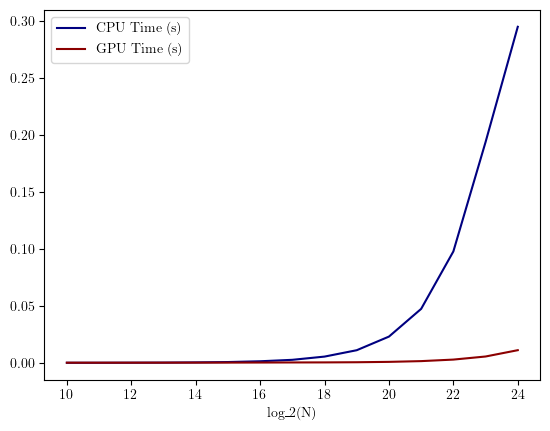

       N  CPU_Time  GPU_Time
0   1024  0.000018  0.000105
1   2048  0.000034  0.000106
2   4096  0.000092  0.000117
3   8192  0.000165  0.000131
4  16384  0.000359  0.000154


In [87]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Computer Modern'

times = pd.read_csv('./timing.csv',sep=',')

plt.plot(np.log2(times['N']), times['CPU_Time'],label='CPU Time (s)',color='navy')
plt.plot(np.log2(times['N']), times['GPU_Time'],label='GPU Time (s)',color='darkred')

plt.xlabel('log_2(N)')
plt.legend()

plt.savefig('./timing_wavelets.png',bbox_inches='tight', pad_inches=0,dpi=300)
plt.show()

print(times.head())